In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from ete2 import NCBITaxa
import re
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as offline

#### 12 regions TARA ocean co-assembly were used.

##### checking number of contigs for each co-assembly

```
cd ../TARA_CONTIGS
find *.fa -printf 'echo %p\t"$(grep -c ">" %p )";' | sh > contig_numbers.tsv
``` 



In [2]:
contignumber=pd.read_csv("../TARA_CONTIGS/contig_numbers.tsv",sep="\s",header=None,engine='python')
contignumber["sample"]=contignumber[0].str.replace(".fa","")
contignumber.drop(0,axis=1,inplace=True)
contignumber.rename(columns={1:"Contigs"},inplace=True)

In [3]:
contignumber

,Contigs,sample
0,1382239,TARA_ANE_RAW
1,1267057,TARA_ANW_RAW
2,766472,TARA_ASE_RAW
3,989154,TARA_ASW_RAW
4,1608737,TARA_ION_RAW
5,1475271,TARA_IOS_RAW
6,1146485,TARA_MED_RAW
7,1663221,TARA_PON_RAW
8,2722083,TARA_PSE_RAW
9,1124813,TARA_PSW_RAW


### Concatenating a fasta with all contigs from 12 regions 

```
cd ../TARA_CONTIGS/
mkdir all
cat *.fa > all/all_contigs.fa
```


#### First, metagenemark was used to extract ORFs 

Using script "metagenmark.sh" 


```
out=$(readlink -f ../TARA_ORFS)/
mkdir -p ${out}/nt
mkdir -p ${out}/ptn

cd ../TARA_CONTIGS

for f in $(ls *.fa );do

~/myproject/MetaGeneMark_linux_64/mgm/./gmhmmp -a -d -m  ~/myproject/MetaGeneMark_linux_64/mgm/MetaGeneMark_v1.mod $f -D ${out}/nt/$f.fna -A ${out}/ptn/$f.faa

```

#### Metagenemark had some problems on format of fasta files, so I had to fix with 
using fix_header.sh
```
#!/bin/bash

inreads=$(readlink -f ../TARA_ORFS)/


logs=$(readlink -f ../slurm_logs)/

cd ${inreads}/nt

for f in $(ls *.fna );do
echo $f
sbatch -c 4 -p hugemem,himem,blade -o ${logs}fixheader_${f}.%j.out << EOF
#!/bin/bash
sed -i -e 's/>TARA/TARA/g' $f
EOF
done

cd ${inreads}/ptn

for f in $(ls *.faa );do
echo $f
sbatch -c 4 -p hugemem,himem,blade -o ${logs}fixheader_${f}.%j.out << EOF
#!/bin/bash
sed -i -e 's/>TARA/TARA/g' $f
EOF
done
```

PS: also problems with the first line in some files =  blank line, edited manually but need to fix it

### Generating tabular files with contigs id -- gene ids

```
for f in $(ls ../TARA_ORFS/nt/*.fna);do grep ">" $f > ${f%.fa.fna}_orf_contigs.tsv;done 
for f in $(ls ../TARA_ORFS/ptn/*.faa);do grep ">" $f > ${f%.fa.faa}_orf_contigs.tsv;done 

```

checking number of contigs for each co-assembly
``` 
cd ../TARA_ORFS/nt
find *.fna -printf 'echo %p\t"$(grep -c ">" %p )";' | sh > orf_numbers.tsv
``` 

In [4]:
orfnumber=pd.read_csv("../TARA_ORFS/nt/orf_numbers.tsv",sep="\s",header=None,engine='python')
orfnumber["sample"]=orfnumber[0].str.replace(".fa.fna","")
orfnumber.drop(0,axis=1,inplace=True)
orfnumber.rename(columns={1:"ORFs"},inplace=True)
table_number_paper=pd.merge(contignumber,orfnumber,on="sample")
table_number_paper=table_number_paper[["sample","Contigs","ORFs"]]


In [5]:
table_number_paper

,sample,Contigs,ORFs
0,TARA_ANE_RAW,1382239,3686619
1,TARA_ANW_RAW,1267057,3308183
2,TARA_ASE_RAW,766472,1842937
3,TARA_ASW_RAW,989154,2502625
4,TARA_ION_RAW,1608737,4257000
5,TARA_IOS_RAW,1475271,3736229
6,TARA_MED_RAW,1146485,3344341
7,TARA_PON_RAW,1663221,4368436
8,TARA_PSE_RAW,2722083,7155344
9,TARA_PSW_RAW,1124813,3080817


In [6]:
table_number_paper["Contigs"].sum()

15600278

In [7]:
table_number_paper["ORFs"].sum()

41249791

### Open the tabular files generated, concatanating in a new dataframe

In [8]:
path_arg="../TARA_ORFS/nt/"
files  = os.listdir(path_arg)


contig_gene_ids=pd.DataFrame()
for f in files:
    if f.endswith(".tsv") and f.startswith("TARA"):
        df2=pd.read_csv(path_arg+f,sep="\s",header=None,engine='python')
        df2["sample"]=f
        contig_gene_ids=pd.concat([contig_gene_ids,df2])
        
contig_gene_ids.columns=["read_id","contig_id","sample"]
contig_gene_ids["read_id"]=contig_gene_ids["read_id"].str.replace(">","")
contig_gene_ids["sample"]=contig_gene_ids["sample"].str.replace("_orf_contigs.tsv","")

path_arg="../TARA_ORFS/ptn/"
files  = os.listdir(path_arg)


contig_gene_ids_ptn=pd.DataFrame()
for f in files:
    if f.endswith(".tsv") and f.startswith("TARA"):
        df2=pd.read_csv(path_arg+f,sep="\s",header=None,engine='python')
        df2["sample"]=f
        contig_gene_ids_ptn=pd.concat([contig_gene_ids_ptn,df2])
        
contig_gene_ids_ptn.columns=["read_id","contig_id","sample"]
contig_gene_ids_ptn["read_id"]=contig_gene_ids_ptn["read_id"].str.replace(">","")
contig_gene_ids_ptn["sample"]=contig_gene_ids_ptn["sample"].str.replace("_orf_contigs.tsv","")

contig_gene_ids_ptn["gene"]=contig_gene_ids_ptn["read_id"].str.split("|",expand=True)[0]
contig_gene_ids["gene"]=contig_gene_ids["read_id"].str.split("|",expand=True)[0]
new_contig_gene_ids=pd.merge(contig_gene_ids,contig_gene_ids_ptn,on=["gene","contig_id","sample"])
new_contig_gene_ids.drop("gene",axis=1,inplace=True)
new_contig_gene_ids.rename(columns={"read_id_x":"read_id","read_id_y":"ptn_id"},inplace=True)

In [9]:
new_contig_gene_ids.head()

,read_id,contig_id,sample,ptn_id
0,gene_1|GeneMark.hmm|261_nt|-|329|589,TARA_SOC-k99_292,TARA_SOC_RAW,gene_1|GeneMark.hmm|86_aa|-|329|589
1,gene_2|GeneMark.hmm|372_nt|-|590|961,TARA_SOC-k99_292,TARA_SOC_RAW,gene_2|GeneMark.hmm|123_aa|-|590|961
2,gene_3|GeneMark.hmm|210_nt|+|3|212,TARA_SOC-k99_298,TARA_SOC_RAW,gene_3|GeneMark.hmm|69_aa|+|3|212
3,gene_4|GeneMark.hmm|558_nt|-|1|558,TARA_SOC-k99_312,TARA_SOC_RAW,gene_4|GeneMark.hmm|186_aa|-|1|558
4,gene_5|GeneMark.hmm|474_nt|-|555|1028,TARA_SOC-k99_312,TARA_SOC_RAW,gene_5|GeneMark.hmm|157_aa|-|555|1028


#### deepARG was used to find ARGs in each region
using deepARG.sh
```
#!/bin/bash

inreads=$(readlink -f ../TARA_ORFS/nt)/
deep=$(readlink -f /beegfs/group_bit/home/RCuadrat/projects/Bioinformatics/bit_FLPA/scripts.RCuadrat/deeparg-ss)/

mkdir -p ../deeparg_out
out=$(readlink -f ../deeparg_out)/
logs=$(readlink -f ../slurm_logs)/

cd ${inreads}
for f in $(ls *.fna );do
echo $f
sbatch -c 18 -p hugemem,himem,blade -o ${logs}deep_${f}.%j.out << EOF
#!/bin/bash
python ${deep}deepARG.py --align --type nucl --genes --input $f --output ${out}${f%.fna}.out
EOF
done

```


### Parsing deepARG results

In [10]:
path_arg="../deeparg_out/"
files  = os.listdir(path_arg)

In [11]:
deepARG=pd.DataFrame()
for f in files:
    if f.endswith(".mapping.ARG"):
        df=pd.read_csv(path_arg+f,sep="\t")
        df["sample"]=f
        deepARG=pd.concat([deepARG,df])
deepARG["gene"]=deepARG["best-hit"].str.split("|",expand=True)[4]
deepARG["sample"]=deepARG["sample"].str.replace(".fa.out.mapping.ARG","")

In [12]:
deepARG.head()

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,alignment-evalue,problematic_classification,sample,gene
0,PATA,76,441,gene_4195642|GeneMark.hmm|1125_nt|+|2|1126,quinolone,NP_417544.5|FEATURES|CARD|quinolone|patA,0.921137,35.1,370,204.1,6.700000e-53,1,TARA_ION_RAW,patA
1,MSRB,14,133,gene_1913961|GeneMark.hmm|393_nt|-|670|1062,macrolide-lincosamide-streptogramin,NP_416292.1|FEATURES|CARD|macrolide-lincosamid...,0.974641,40.5,121,92.8,7.600000e-20,1,TARA_ION_RAW,msrB
2,UPPP,47,263,gene_3637740|GeneMark.hmm|687_nt|+|1|687,bacitracin,A5KNX8|FEATURES|UNIPROT|bacitracin|uppP,1.000000,32.6,227,77.4,5.800000e-15,1,TARA_ION_RAW,uppP
3,PATA,76,447,gene_222026|GeneMark.hmm|1164_nt|+|198|1361,quinolone,NP_417544.5|FEATURES|CARD|quinolone|patA,0.870956,30.4,375,169.5,1.900000e-42,1,TARA_ION_RAW,patA
4,GOLS,1,129,gene_2742391|GeneMark.hmm|393_nt|-|2005|2397,multidrug,NP_459349.1|FEATURES|CARD|multidrug|golS,0.988998,51.9,129,138.7,1.200000e-33,1,TARA_ION_RAW,golS


In [13]:
#deepARG=deepARG[deepARG["#ARG"]!="MSRB"]

In [14]:
set(deepARG["predicted_ARG-class"])

{'aminocoumarin',
 'aminoglycoside',
 'bacitracin',
 'beta_lactam',
 'bleomycin',
 'chloramphenicol',
 'fosfomycin',
 'fosmidomycin',
 'glycopeptide',
 'kasugamycin',
 'macrolide-lincosamide-streptogramin',
 'multidrug',
 'multidrug-mutation',
 'mupirocin',
 'peptide',
 'pleuromutilin',
 'polymyxin',
 'puromycin',
 'qa_compound',
 'quinolone',
 'rifampin',
 'streptothricin',
 'sulfonamide',
 'tetracenomycin',
 'tetracycline',
 'thiostrepton',
 'triclosan',
 'trimethoprim'}

In [15]:
#How many ORFs from each class?

### this is not normalized by the actually real number of genes from each class on the database

##### another ideia is to to enrichment analysis: background is the deepARG database (number of ARGs per class)

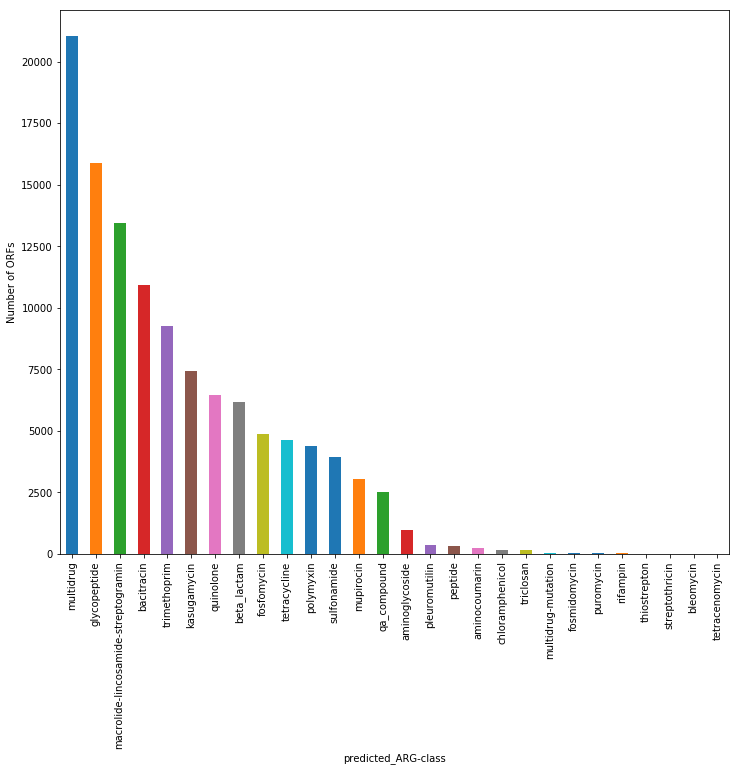

In [16]:
plt.figure(figsize=(12,10))
deepARG.groupby(["predicted_ARG-class"])["#ARG"].count().sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

In [17]:
deepARG

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,alignment-evalue,problematic_classification,sample,gene
0,PATA,76,441,gene_4195642|GeneMark.hmm|1125_nt|+|2|1126,quinolone,NP_417544.5|FEATURES|CARD|quinolone|patA,0.921137,35.1,370,204.1,6.700000e-53,1,TARA_ION_RAW,patA
1,MSRB,14,133,gene_1913961|GeneMark.hmm|393_nt|-|670|1062,macrolide-lincosamide-streptogramin,NP_416292.1|FEATURES|CARD|macrolide-lincosamid...,0.974641,40.5,121,92.8,7.600000e-20,1,TARA_ION_RAW,msrB
2,UPPP,47,263,gene_3637740|GeneMark.hmm|687_nt|+|1|687,bacitracin,A5KNX8|FEATURES|UNIPROT|bacitracin|uppP,1.000000,32.6,227,77.4,5.800000e-15,1,TARA_ION_RAW,uppP
3,PATA,76,447,gene_222026|GeneMark.hmm|1164_nt|+|198|1361,quinolone,NP_417544.5|FEATURES|CARD|quinolone|patA,0.870956,30.4,375,169.5,1.900000e-42,1,TARA_ION_RAW,patA
4,GOLS,1,129,gene_2742391|GeneMark.hmm|393_nt|-|2005|2397,multidrug,NP_459349.1|FEATURES|CARD|multidrug|golS,0.988998,51.9,129,138.7,1.200000e-33,1,TARA_ION_RAW,golS
5,TETB(60),29,239,gene_1224955|GeneMark.hmm|1737_nt|+|8920|10656,tetracycline,ANZ79241.1|FEATURES|CARD|tetracycline|tetB(60),0.926290,30.5,220,96.3,3.000000e-20,1,TARA_ION_RAW,tetB(60)
6,SULA,2,259,gene_3950615|GeneMark.hmm|846_nt|+|396|1241,sulfonamide,P59655|FEATURES|UNIPROT|sulfonamide|sulA,0.932225,35.1,265,135.6,2.200000e-32,1,TARA_ION_RAW,sulA
7,PATA,76,449,gene_467525|GeneMark.hmm|1323_nt|+|18481|19803,quinolone,NP_417544.5|FEATURES|CARD|quinolone|patA,0.925280,33.6,402,208.4,4.200000e-54,1,TARA_ION_RAW,patA
8,KDPE,5,223,gene_1348178|GeneMark.hmm|738_nt|-|3756|4493,aminoglycoside,NP_415222.1|FEATURES|CARD|aminoglycoside|kdpE,0.907377,30.8,227,80.5,7.300000e-16,1,TARA_ION_RAW,kdpE
9,UPPP,16,260,gene_1268059|GeneMark.hmm|765_nt|+|2116|2880,bacitracin,B5YBN3|FEATURES|UNIPROT|bacitracin|uppP,1.000000,30.1,246,99.0,2.100000e-21,1,TARA_ION_RAW,uppP


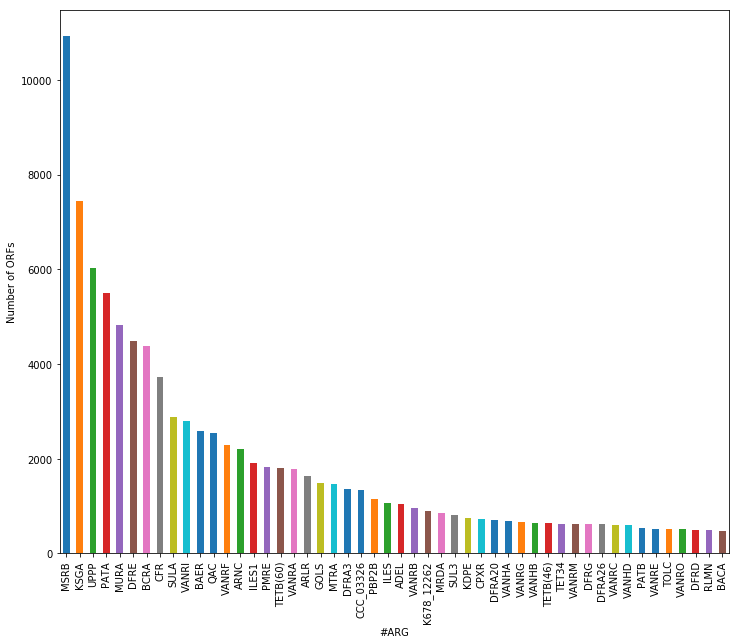

In [18]:
plt.figure(figsize=(12,10))
deepARG.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:50].plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

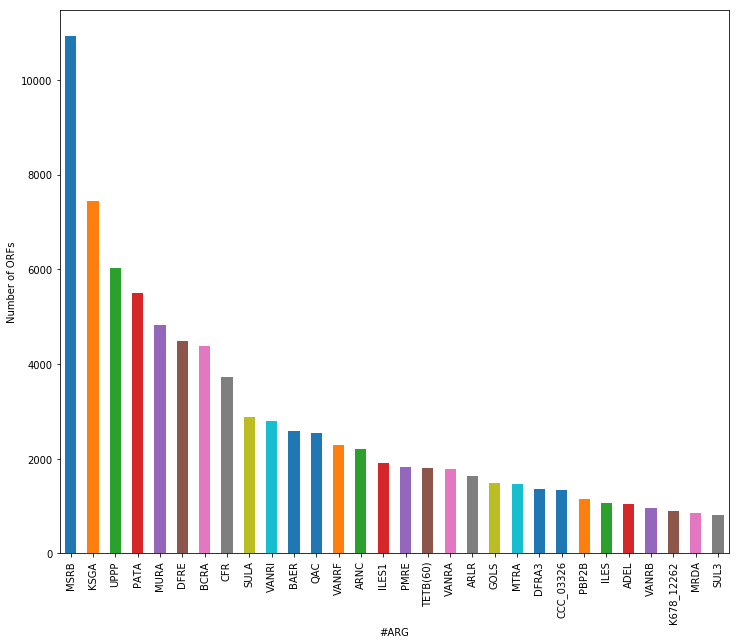

In [19]:
plt.figure(figsize=(12,10))
deepARG.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:30].plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

In [20]:
args_per_sample=pd.DataFrame(deepARG.groupby("sample")["#ARG"].count()).reset_index()

In [21]:
table_number_paper=pd.merge(table_number_paper,args_per_sample,on="sample")

In [22]:
table_number_paper.to_csv("../table1.tsv",sep="\t",index=None)
table_number_paper.to_excel("../table1.xlsx",index=None)

In [23]:
table_number_paper["#ARG"].sum()

116425

### Merging the deepARG results with contig IDs on read id (orf/gene id)

In [24]:
#deepARG_=pd.merge(deepARG,contig_gene_ids,how="left",on=["read_id","sample"])

In [25]:
deepARG_=pd.merge(deepARG,new_contig_gene_ids,how="left",on=["read_id","sample"])

In [26]:
len(set(deepARG_["contig_id"]))

109579

In [27]:
len(set(deepARG_["read_id"]))

116425

In [28]:
## list of contigs with ARGS
deepARG_["contig_id"].drop_duplicates().to_csv("../TARA_CONTIGS/all/all_contigs_with_args.list",index=None,header=None)


### Making files with "reads" (gene ids) from deepARG results

In [ ]:
for f in list(set(deepARG["sample"])):
    tmp=deepARG[deepARG["sample"]==f]
    tmp=tmp["read_id"]
    tmp.to_csv("../TARA_ARGS/"+f.split(".")[0]+".read_list",header=None,index=None)

In [ ]:
for f in list(set(deepARG["sample"])):
    tmp=deepARG_[deepARG_["sample"]==f]
    tmp=tmp["ptn_id"]
    tmp.to_csv("../TARA_ARGS/"+f.split(".")[0]+".ptn_list",header=None,index=None)

### After this step, I used samtools faixd to extract only those ORFs on the lists generated
using faidx_extract.sh
```
#!/bin/bash


inreads=$(readlink -f ../TARA_ORFS)/
inlist=$(readlink -f ../TARA_ARGS)/


cd ${inreads}/ptn

for f in $(ls *.faa );do

sbatch -p dontuseme,himem -c 10 --mem=4gb -o ${f%.fa.faa}_faixd_ext_ptn.out << EOF
#!/bin/bash
module load samtools
xargs samtools faidx ${f} < ${inlist}${f%.fa.faa}.ptn_list > ${inlist}${f%.fa.faa}.ARGS_ptn
EOF

done


cd ${inreads}/nt

for f in $(ls *.fna );do
sbatch -p dontuseme,himem -c 10 --mem=4gb -o ${f%.fa.fna}_faixd_ext_nt.out << EOF
#!/bin/bash
module load samtools
xargs samtools faidx ${f} < ${inlist}${f%.fa.fna}.read_list > ${inlist}${f%.fa.fna}.ARGS
EOF

done

```

### generate fasta with all contigs with at least 1 ARG

```
cd ../TARA_CONTIGS/all/
module load samtools
xargs samtools faidx all_contigs.fa < all_contigs_with_args.list > all_contigs_with_args.fasta
```


## all ORFs from contigs with at least 1 ARG

In [ ]:
contigs_orfs_with_args=new_contig_gene_ids[new_contig_gene_ids["contig_id"].isin(deepARG_["contig_id"].drop_duplicates())].drop_duplicates()

In [ ]:
contigs_orfs_with_args.head()

In [ ]:
!mkdir ../contigs_with_args_orfs

In [ ]:
for s in list(set(contigs_orfs_with_args["sample"])):
    tmp=contigs_orfs_with_args[contigs_orfs_with_args["sample"]==s]
    tmp["read_id"].to_csv("../contigs_with_args_orfs/"+s+"_orfs_in_contigs_with_args.list",header=None,index=None)

## extracting of all ORFs from contigs with at least 1 ARG

```
cd ../TARA_ORFS/nt
for f in $(ls *.fna); do xargs samtools faidx $f < ../../contigs_with_args_orfs/${f%.fa.fna}_orfs_in_contigs_with_args.list > ${f%.fa.fna}.args_orfs.fna;done
```

### PlasFlow 

``` 
./PlasFlow.py --input ../TARA_CONTIGS/all/all_contigs_with_args.fasta --output ~/projects/Bioinformatics/bit_resistome/all_with_args.plasflowout --threshold 0.7
``` 

In [ ]:
pf=pd.read_table("../all_with_args.plasflowout") 
pf.drop(["Unnamed: 0","contig_id"],axis=1,inplace=True)

In [ ]:
pf.head()

In [ ]:
pf_=pf[["contig_name","contig_length","label"]]

In [ ]:
len(pf_)

In [ ]:
deepARG_plas=pd.merge(deepARG_,pf_,left_on="contig_id",right_on="contig_name")

In [ ]:
deepARG_plas['plasmid'] = np.where(deepARG_plas['label'].str.contains("plasmid")==True, 'yes', 'no')


In [ ]:
deepARG_plas.drop("contig_name",axis=1,inplace=True)

In [ ]:
deepARG_plas.head()


In [ ]:
len(deepARG_plas)

In [ ]:
deepARG_plas.groupby("plasmid")["read_id"].count()

In [ ]:
deepARG_plas.groupby("label")["read_id"].count()

In [ ]:
deepARG_plas["Plasflow_phyla"]=deepARG_plas["label"].str.split(".",expand=True)[1]

In [ ]:
deepARG_plas[deepARG_plas["plasmid"]=="yes"].groupby("Plasflow_phyla")["Plasflow_phyla"].count()

In [ ]:
plt.figure(figsize=(10,8))
count=deepARG_plas[deepARG_plas["plasmid"]=="yes"].groupby("Plasflow_phyla")["Plasflow_phyla"].count().values
index=deepARG_plas[deepARG_plas["plasmid"]=="yes"].groupby("Plasflow_phyla")["Plasflow_phyla"].count().index
sns.barplot(index,count)
#plt.bar(range(len(index)),count)
#plt.xticks(range(len(index)), index,rotation="vertical",fontsize="14")
plt.yticks(fontsize="14")
plt.ylabel("Number of ORFs in plasmids",fontsize="12")
#plt.xlabel("Phylum",fontsize="14")
plt.show()



In [ ]:
deepARG_plas[deepARG_plas["plasmid"]=="no"].groupby("Plasflow_phyla")["Plasflow_phyla"].count()

In [ ]:
plt.figure(figsize=(10,8))
count=deepARG_plas[deepARG_plas["plasmid"]=="no"].groupby("Plasflow_phyla")["Plasflow_phyla"].count().values
index=deepARG_plas[deepARG_plas["plasmid"]=="no"].groupby("Plasflow_phyla")["Plasflow_phyla"].count().index
sns.barplot(index,count)
#plt.bar(range(len(index)),count)
plt.xticks(rotation="vertical")
plt.yticks(fontsize="12")
plt.ylabel("Number of ORFs in chr",fontsize="12")
#plt.xlabel("Phylum",fontsize="12")
plt.show()

### counting ORFs with ARGS for each class in each sample (region)

In [ ]:
classes_regions_orfs=pd.DataFrame(deepARG_plas.groupby(["predicted_ARG-class","sample","plasmid"])["read_id"].count())

In [ ]:
test_graphic=classes_regions_orfs.reset_index("predicted_ARG-class")

In [ ]:
# for a in set(test_graphic["predicted_ARG-class"]):
#     tmp_g=test_graphic[test_graphic["predicted_ARG-class"]==a]
#     plt.figure(figsize=(10,10))
#     sns.barplot(tmp_g.index,tmp_g["read_id"])
#     plt.xticks(rotation="vertical",fontsize="12")
#     #tmp_g.plot(kind="bar",legend=False)
#     plt.title(a)
#     plt.ylabel("Number of ORFs")
#     plt.show()

In [ ]:
# classes_regions_orfs.plot(kind="bar")
# plt.show()

In [ ]:
suplementar_1=pd.DataFrame(deepARG_plas.groupby(["predicted_ARG-class","sample"])["read_id"].count())

In [ ]:
suplementar_1.columns=["Number of ORFs"]

In [ ]:
suplementar_1.head()

In [ ]:
suplementar_1.to_excel("../suplementar1.xlsx")

In [ ]:
classes_regions_orfs.head()

In [ ]:
classes_regions_orfs.to_excel("../Table2_.xlsx")

### Extract fasta files for each ARG for phylogeny

#### First, I had to add info of sample (REGION) name to the headers in the ARGs fasta files:

```
cd ../TARA_ARGS

for f in $(ls *.ARGS);do awk -v var=${f%.ARGS} '/^>/ {$0=$0 "|"var}1' $f > $f.edit.fasta; done
for f in $(ls *.ARGS_ptn);do awk -v var=${f%.ARGS_ptn} '/^>/ {$0=$0 "|"var}1' $f > $f.edit.ptn.fasta; done
```
#### After, concatenated all the fastas from all regions, generating all ORFs with ARGS into one fasta
```
cat *.edit.fasta  > ALL_ARGS.fasta
cat *.edit.ptn.fasta  > ALL_ARGS_ptn.fasta
```


    
    

### Kaiju LCA 
```
Web server - Results
Job Parameters
Job ID: 110552-8280375508
Job Name: testargs
Reference database: nr +euk
Database date: 2017-05-16
SEG low complexity filter: yes
Run mode: greedy
Minimum match length: 11
Minimum match score: 75
Allowed mismatches: 5

Metagenome Overview
114608 out of 116425 reads were classified.
```

In [ ]:
kaiju=pd.read_table("../kaiju.out",header=None)

In [ ]:
kaiju=kaiju[[1,2]]
kaiju.columns=["ORF_ID","taxon_kaiju"]

In [ ]:
ncbi = NCBITaxa()
taxid2name = ncbi.get_taxid_translator(list(kaiju["taxon_kaiju"].drop_duplicates()))
taxonclassification=pd.DataFrame([taxid2name]).melt()
taxonclassification.columns=["taxon_kaiju","taxon_name_kaiju"]

In [ ]:
kaiju=pd.merge(kaiju,taxonclassification,on="taxon_kaiju",how="left")

In [ ]:
kaiju.head()

In [ ]:
#deepARG_plas.head()

In [ ]:
deepARG_plas["ORF_ID"]=deepARG_plas["read_id"]+"|"+deepARG_plas["sample"]

In [ ]:
deepARG_plas_kaiju=pd.merge(deepARG_plas,kaiju,on="ORF_ID",how="left")

In [ ]:
deepARG_plas_kaiju.head()

In [ ]:
#!wget http://kaiju.binf.ku.dk/output/110552-8280375508/kaiju.taxonpaths.txt

In [ ]:
kaiju_path=pd.read_csv("../kaiju.taxonpaths.txt",header=None,sep="/t")

In [ ]:
kaiju_path=kaiju_path[0].str.split("\t",expand=True)

In [ ]:
kaiju_path[0]=kaiju_path[0].astype(int)

In [ ]:
kaiju_virus=kaiju_path[kaiju_path[2]=="Viruses"]

In [ ]:
plt.figure(figsize=(12,10))
kaiju_virus.groupby(4)[0].sum().sort_values(ascending=False).plot(kind="bar")
plt.show()

In [ ]:
kaiju_level5=kaiju_path[[0,5]]#.groupby(5)[0]

In [ ]:
kaiju_level5[0]=kaiju_level5[0].astype(int)

In [ ]:
kaiju_level5.head()

In [ ]:
plt.figure(figsize=(12,10))
kaiju_level5.groupby(5)[0].sum().sort_values(ascending=False)[0:30].plot(kind="bar")
plt.show()

In [ ]:
#deepARG_plas_kaiju.groupby("taxon_name_kaiju")["#ARG"].count().sort_values(ascending=False)

In [ ]:
#deepARG_plas_kaiju[deepARG_plas_kaiju["#ARG"].str.contains("VANB")==True]

In [ ]:
deepARG_plas_kaiju.to_excel("../all_ORFS_ARGS_plas_kaiju.xlsx",index=None)



In [ ]:
#deepARG_plas_kaiju.head()

In [ ]:
#deepARG_plas_kaiju[deepARG_plas_kaiju["#ARG"]=="MCR-1"]

### generating a list of  IDs "read_id" (orfs) with sample  (region) information to be used to extract indidual ARG fasta from all_ARGs.fasta

In [ ]:
all_ARGS=list(set(deepARG_plas["#ARG"]))
df_tmp_list=deepARG_plas[["#ARG","ORF_ID","sample"]]

In [ ]:
df_tmp_list.head()

In [ ]:
!mkdir -p ../ARG_ORFs_lists

In [ ]:
for a in all_ARGS:
    tmp=df_tmp_list[df_tmp_list["#ARG"]==a]
    #tmp["out"]=tmp["read_id"]+"|"+tmp["sample"]
    #tmp["out"].to_csv("../ARG_list/"+re.sub('[^a-zA-Z0-9 \n\.]', '', a)+".list",header=None,index=None)
    tmp["ORF_ID"].to_csv("../ARG_ORFs_lists/"+re.sub('[^a-zA-Z0-9 \n\.]', '', a)+".list",header=None,index=None)

In [ ]:
all_ARGS=list(set(deepARG_plas["#ARG"]))
df_tmp_list_ptn=deepARG_plas[["#ARG","ptn_id","sample"]]

In [ ]:
!mkdir -p ../ARG_ORFs_lists/ptn

In [ ]:
for a in all_ARGS:
    tmp=df_tmp_list_ptn[df_tmp_list_ptn["#ARG"]==a]
    #tmp["out"]=tmp["read_id"]+"|"+tmp["sample"]
    #tmp["out"].to_csv("../ARG_list/"+re.sub('[^a-zA-Z0-9 \n\.]', '', a)+".list",header=None,index=None)
    tmp["ptn_id"]=tmp["ptn_id"]+"|"+tmp["sample"]
    tmp["ptn_id"].to_csv("../ARG_ORFs_lists/ptn/"+re.sub('[^a-zA-Z0-9 \n\.]', '', a)+".list",header=None,index=None)
    

In [ ]:
deepARG_plas_kaiju.head()

In [ ]:
deepARG_plas_kaiju["new_header_ptn"]=deepARG_plas_kaiju["ptn_id"].str.split("|",expand=True)[0]+"|"+deepARG_plas_kaiju["sample"]+"|"+deepARG_plas_kaiju["taxon_name_kaiju"].fillna("--")+"|"+deepARG_plas_kaiju["plasmid"]

In [ ]:
df_tmp_list_ptn=deepARG_plas_kaiju[["#ARG","ptn_id","sample","new_header_ptn"]]
for a in all_ARGS:
    tmp=df_tmp_list_ptn[df_tmp_list_ptn["#ARG"]==a]
    
    tmp["ptn_id"]=tmp["ptn_id"]+"|"+tmp["sample"]
    tmp[["ptn_id","new_header_ptn"]].to_csv("../ARG_ORFs_lists/ptn/"+re.sub('[^a-zA-Z0-9 \n\.]', '', a)+".list_toedit",sep="\t",header=None,index=None)
    

In [ ]:
deepARG_plas_kaiju.columns

In [ ]:
deepARG_plas_kaiju.rename(columns={"read_id":"nt_id","new_header_ptn":"header_ptn_for_phylogeny"},inplace=True)

In [ ]:
deepARG_plas_kaiju.head()

In [ ]:
#deepARG_plas_kaiju["label"]

In [ ]:
deepARG_plas_kaiju.to_csv("../deepARG_plas_kaiju.tsv",sep="\t",index=None)

### generate the fasta from the lists
```
cd ../ARG_ORFs_lists
for f in $(ls *.list);do xargs samtools faidx ../TARA_ARGS/ALL_ARGS.fasta <  $f > ${f%.list}.fasta;done

cd ../ARG_ORFs_lists/ptn
for f in $(ls *.list);do xargs samtools faidx ../../TARA_ARGS/ALL_ARGS_ptn.fasta <  $f > ${f%.list}.fasta;done

```

### editing the header for phylogeny

```
./seqkit replace -p "(.+)" -r '{kv}' -k ARG_ORFs_lists/ptn/MSBA.list_toedit ARG_ORFs_lists/ptn/MSBA.fasta > ARG_ORFs_lists/ptn/MSBA_ptn_edit.fasta
```

### Checking contigs with multiple ARGs

In [ ]:
multiple_ARGS=deepARG_plas.groupby(["contig_id","plasmid"])["#ARG"].count()
multiple_ARGS=pd.DataFrame(multiple_ARGS)
multiple_ARGS=multiple_ARGS[multiple_ARGS["#ARG"]>2]

In [ ]:
multiple_ARGS_distribution=pd.DataFrame(multiple_ARGS.groupby(["#ARG","plasmid"])["#ARG"].count())
multiple_ARGS_distribution.columns=["Number of contigs"]
multiple_ARGS_distribution.reset_index(inplace=True)
multiple_ARGS_distribution.columns=["Number of #ARGs","plasmid","Number of contigs"]

In [ ]:
## List of contig ids for those with more than 2 ARGs
## It will be used to generate a fasta with those contigs for chimera analysis
multiple_ARGS.reset_index()["contig_id"].to_csv("../TARA_CONTIGS/all/contigs_multiple_ARGS.list",header=None,index=None)

## Table with contigs with multiple args and the number of args they have for suplementar material
multiple_ARGS.to_excel("../multiple_ARGs_contig_dist.xlsx")

In [ ]:
full_Table_multiARGS=deepARG_plas_kaiju[deepARG_plas_kaiju["contig_id"].isin(list(multiple_ARGS.reset_index()["contig_id"]))]

In [ ]:
full_Table_multiARGS[["#ARG","predicted_ARG-class","contig_id","plasmid","taxon_name_kaiju"]].head()

In [ ]:
multi_args_contigs=full_Table_multiARGS.groupby("contig_id")["#ARG"].count().sort_values(ascending=False)

In [ ]:
#multi_args_contigs[0:2].index

In [ ]:
#full_Table_multiARGS[full_Table_multiARGS["contig_id"].isin(multi_args_contigs[0:1].index)]#["predicted_ARG-class"])

### extract contigs multiple ARGS (>2) from all_contigs.fa
```
cd ../TARA_CONTIGS/all
samtools faidx all_contigs.fa < contigs_multiple_ARGS.list > contigs_multiple_ARGS.fasta
```

In [ ]:
#melhorar esse grafico

multiple_ARGS_distribution.set_index(["Number of #ARGs","plasmid"]).unstack().plot(kind="bar",stacked=True)
plt.legend(["chr","plasmid"])
plt.ylabel("Number of Contigs")
plt.show()

In [ ]:
multiple_ARGS_distribution#["Number of contigs"]

In [ ]:
plt.figure(figsize=(12,10))
deepARG.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:30].plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

# QUANTIFICATION from here ...

In [ ]:
# Gambiarra pra definir regioes



regions=["TARA_ANE_RAW","ARA_ANW_RAW","TARA_ASE_RAW","TARA_ASW_RAW","TARA_ION_RAW","TARA_IOS_RAW","TARA_MED_RAW","TARA_PON_RAW","TARA_PSE_RAW","TARA_PSW_RAW","TARA_RED_RAW","TARA_SOC_RAW"]



### Mapping reads (382 samples) to ARGs extracted (12 regions) for quantification of ARGs on samples
using bbmap.sh

``` 

#!/bin/bash


inreads=$(readlink -f ../reads)/
inref=../TARA_ARGS/ALL_ARGS.fasta
out=$(readlink -f ../bbmap_out)/
logs=$(readlink -f ../slurm_logs)/

cd ${inreads}

        for f in $(ls *1.fastq );do
sbatch -p dontuseme -c 18 -o ${logs}/${f%.fastq}_bbmap.%j.out << EOF
#!/bin/bash
module load java
bbmap.sh touppercase=t ref=${inref}  scafstats=${out}/ALL_ARG_${f%_1.fastq}.cov  in1=$f in2=${f%1.fastq}2.fastq out=${out}/ALL_ARG_${f%_1.fastq}.sam rpkm=${out}/ALL_ARG_${f%_1.fastq}.rpkm 
rm ${out}/ALL_ARG_${f%_1.fastq}.sam
EOF

done
```






### Parsing bbmap_out with FPKMs (all samples X  all ARGs from 12 regions)

In [ ]:
## mapping to the concatenated version (all args from all regions as reference)

In [ ]:
path_arg="../bbmap_out/"
files  = os.listdir(path_arg)
all_FPKM=pd.DataFrame()
reg=pd.DataFrame(columns=["ORF_ID"])
for f in files:
    if f.endswith(".rpkm"):
        sample=f.split("_")[-1].split(".")[0]
        df2=pd.read_csv(path_arg+f,sep="\t",skiprows=4)
        df2=df2[["#Name","FPKM"]]
        #df2.columns=["read_id",sample+"_FPKM"]
        df2.columns=["ORF_ID",sample]
        reg=pd.merge(reg,df2,on="ORF_ID",how="outer")
all_FPKM=pd.concat([all_FPKM,reg])
all_FPKM["sample"]=all_FPKM["ORF_ID"].str.split("|",expand=True)[6]

In [ ]:
all_FPKM.head()

In [ ]:
all_FPKM.drop("sample",axis=1).to_csv("../FPKMs.tsv",sep="\t",index=None)

### Merging deepARG results with bbmap (FPKM)

In [ ]:
#all_results=pd.merge(deepARG_plas_,all_FPKM,left_on=["ORF_ID","sample"],right_on=["read_id","sample"],how="outer")
all_results=pd.merge(deepARG_plas_kaiju,all_FPKM,on=["ORF_ID","sample"],how="outer")


In [ ]:
# all_results.drop("read_id_x",axis=1,inplace=True)
# all_results.drop("read_id_y",axis=1,inplace=True)

In [ ]:
all_results.to_csv("../merged_deepARG_kaiju_plas_FPKM.csv",index=None,sep="\t")

In [ ]:
#all_results.head()

In [ ]:
#all_results[all_results["#ARG"]=="BLA"]

In [ ]:
#all_results[all_results["#ARG"]=="MCR-1"]

### Grouping by ARG and sum of FPKMs

In [ ]:
ARGS_FPKM=all_results.groupby(["#ARG"])[[x for x in all_results.columns if "ERR" in x]].sum()

In [ ]:
len(ARGS_FPKM)

In [ ]:
from  scipy.stats import spearmanr 

In [ ]:
ARGS_FPKM.T.head()

In [ ]:
rho,pvalue=spearmanr(ARGS_FPKM.T)
pv_df=pd.DataFrame(pvalue)
rho_df=pd.DataFrame(rho)
corrr=ARGS_FPKM.T.corr(method='spearman')
corrr.to_csv("../ARGS_FPKM_spearman_corr.tsv",sep="\t")

In [ ]:
all_results[["#ARG","predicted_ARG-class"]].to_csv("../ARGS_class.tsv",sep="\t")

In [ ]:
#ARGS_FPKM.T.corr().to_csv("../ARGS_FPKM_corr.tsv",sep="\t")

In [ ]:
args_genes_sum=ARGS_FPKM.sum(axis=1)

In [ ]:
plt.figure(figsize=(12,10))
args_genes_sum.sort_values(ascending=False)[0:30].plot(kind="bar")
plt.ylabel("FPKM")
plt.show()

In [ ]:
args_genes_sum_samples=ARGS_FPKM.sum(axis=0)

In [ ]:
gene_FPKM=all_results.groupby(["#ARG"])[[x for x in all_results.columns if "ERR" in x]].sum()
new_gene_FPKM=gene_FPKM.T
new_gene_FPKM.reset_index(inplace=True)
new_gene_FPKM["sample"]=new_gene_FPKM["index"].str.replace("_FPKM","")
new_gene_FPKM.drop("index",axis=1,inplace=True)

In [ ]:
new_gene_FPKM.head()

### Grouping by ARG class  and sum of FPKMs

In [ ]:
#here, sum but maybe mean to normalize by number of genes on each class ?

class_FPKM=all_results.groupby(["predicted_ARG-class"])[[x for x in all_results.columns if "ERR" in x]].sum()
new_classes_FPKM=class_FPKM.T
new_classes_FPKM.reset_index(inplace=True)
new_classes_FPKM["sample"]=new_classes_FPKM["index"].str.replace("_FPKM","")
new_classes_FPKM.drop("index",axis=1,inplace=True)

In [ ]:
new_classes_FPKM.head()

In [ ]:
plt.figure(figsize=(12,10))
class_FPKM.sum(axis=1).sort_values(ascending=False).plot(kind="bar")
plt.ylabel("FPKM")
plt.show()

In [ ]:
#class_FPKM.sum(axis=1).sort_values(ascending=False)

### TARA metadata

In [ ]:
meta=pd.read_csv("/beegfs/group_bit/data/projects/departments/Bioinformatics/bit_FLPA/tara/meta.tsv",sep="\t")
meta_=pd.merge(meta,meta["INSDC run accession number(s)"].str.split("|",expand=True).T.melt().dropna(),left_index=True,right_on="variable")
meta2=pd.read_csv("/beegfs/group_bit/data/projects/departments/Bioinformatics/bit_FLPA/tara/meta2.tsv",sep="\t",decimal=",")
meta3=pd.merge(meta_,meta2,left_on="PANGAEA sample identifier",right_on="PANGAEA Sample ID")
meta4=meta3[["Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]","value"]]
meta4.columns=["Regions","sample"]

In [ ]:
meta_.rename(columns={"Marine pelagic biomes (Longhurst 2007)":"Biogeographic biomes (Longhurst 2007)"},inplace=True)
meta_.rename(columns={"Marine pelagic biomes  (Longhurst 2007) [MRGID registered at www.marineregions.com] ":"Marine provinces  (Longhurst 2007)"},inplace=True)
meta_.drop("variable",axis=1).to_csv("../meta_runs.tsv",sep="\t",index=None)
meta2.to_csv("../meta2.tsv",sep="\t",index=None)

In [ ]:
# meta_[meta_["Sample label [TARA_station#_environmental-feature_size-fraction]"].str.contains("<-0.22")==True]["value"].to_csv("../tara/ids_virus.txt",index=None,header=None)
# list_ids=pd.read_table("../tara/id.list",header=None)
# list_ids.columns=["value"]
# check=meta_[["Sample label [TARA_station#_environmental-feature_size-fraction]","value"]]
# #samples_merged=pd.merge(list_ids,check,on="value",how="outer")
# #samples_merged

In [ ]:
#meta_.head()

### Merging Classes FPKM with info of regions of samples

In [ ]:
new_classes_FPKM=pd.merge(new_classes_FPKM,meta4,on="sample")
new_classes_FPKM.set_index(["sample","Regions"],inplace=True)
new_classes_FPKM.reset_index(inplace=True)

In [ ]:
#new_classes_FPKM.head()

In [ ]:
# the same but for genes instead classes

new_gene_FPKM=pd.merge(new_gene_FPKM,meta4,on="sample")
new_gene_FPKM.set_index(["sample","Regions"],inplace=True)
new_gene_FPKM.reset_index(inplace=True)


In [ ]:
#new_gene_FPKM.head()

In [ ]:
#new_gene_FPKM

### Normalizing the sum of FPKM per number of samples on the region

In [ ]:
new_classes_FPKM_norm_region=new_classes_FPKM.groupby("Regions").mean()

In [ ]:
#new_classes_FPKM_norm_region.head()

In [ ]:
new_gene_FPKM_norm_region=new_gene_FPKM.groupby("Regions").mean()

In [ ]:
#new_gene_FPKM_norm_region.head()

In [ ]:
new_classes_FPKM.set_index("sample",inplace=True)
new_gene_FPKM.set_index("sample",inplace=True)

In [ ]:
groups= list(set(new_classes_FPKM["Regions"]))

classes=list(set(all_results["predicted_ARG-class"]))

genes=list(set(all_results["#ARG"]))

In [ ]:
genes_test=pd.DataFrame()
for g in genes:
    #print g

    f,p=stats.f_oneway(new_gene_FPKM[new_gene_FPKM["Regions"]==groups[0]][g],new_gene_FPKM[new_gene_FPKM["Regions"]==groups[1]][g],new_gene_FPKM[new_gene_FPKM["Regions"]==groups[2]][g],
                     new_gene_FPKM[new_gene_FPKM["Regions"]==groups[3]][g],new_gene_FPKM[new_gene_FPKM["Regions"]==groups[4]][g],
                    new_gene_FPKM[new_gene_FPKM["Regions"]==groups[5]][g],new_gene_FPKM[new_gene_FPKM["Regions"]==groups[6]][g],
                    new_gene_FPKM[new_gene_FPKM["Regions"]==groups[7]][g])
    #print f,p 
    
    tmp=pd.DataFrame([g,f,p]).T
    tmp.columns=["gene","fvalue","pvalue"]
    
    genes_test=pd.concat([genes_test,tmp],axis=0)
genes_test.reset_index(inplace=True,drop=True)

In [ ]:
genes_test.head()

In [ ]:
class_test=pd.DataFrame()

for c in classes:
    #print c
    f,p=stats.f_oneway(new_classes_FPKM[new_classes_FPKM["Regions"]==groups[0]][c],new_classes_FPKM[new_classes_FPKM["Regions"]==groups[1]][c],new_classes_FPKM[new_classes_FPKM["Regions"]==groups[2]][c],
                     new_classes_FPKM[new_classes_FPKM["Regions"]==groups[3]][c],new_classes_FPKM[new_classes_FPKM["Regions"]==groups[4]][c],
                    new_classes_FPKM[new_classes_FPKM["Regions"]==groups[5]][c],new_classes_FPKM[new_classes_FPKM["Regions"]==groups[6]][c],
                    new_classes_FPKM[new_classes_FPKM["Regions"]==groups[7]][c])
    #print f,p 
    tmp=pd.DataFrame([c,f,p]).T
    tmp.columns=["class","fvalue","pvalue"]
    
    class_test=pd.concat([class_test,tmp],axis=0)
class_test.reset_index(inplace=True,drop=True)

In [ ]:
class_test.head()

In [ ]:
new_gene_FPKM["Regions"]=new_gene_FPKM["Regions"].str.split("[",expand=True)[0]

In [ ]:
import matplotlib.backends.backend_pdf

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../tukey_genes.pdf")
all_g=pd.DataFrame()
for g in genes:
    #print g

    tukey = pairwise_tukeyhsd(endog=new_gene_FPKM[g],     # Data
                              groups=new_gene_FPKM["Regions"],   # Groups
                              alpha=0.05)          # Significance level

    fig=tukey.plot_simultaneous()    # Plot group confidence intervals
    plt.title(g)
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
    df=tukey.summary()
    res=pd.DataFrame(df.data[1:],columns=df.data[0])
    res["gene"]=str(g)
    all_g=pd.concat([all_g,res])
pdf.close()

In [ ]:
plt.close()

In [ ]:
meta_.columns

In [ ]:
meta5=meta_[["value","Marine provinces  (Longhurst 2007)"]]
meta5.columns=["sample","region2"]

In [ ]:
new_gene_FPKM=pd.merge(new_gene_FPKM.reset_index(),meta5,on="sample")


In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(new_gene_FPKM["region2"],new_gene_FPKM["MCR-1"])
plt.xticks(rotation=90)
plt.ylabel("mean FPKM")
plt.title("MCR-1")
plt.show()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../tukey_class.pdf")
all_c=pd.DataFrame()
for c in classes:
    #print c

    tukey = pairwise_tukeyhsd(endog=new_classes_FPKM[c],     # Data
                              groups=new_classes_FPKM["Regions"],   # Groups
                              alpha=0.05)          # Significance level

    fig=tukey.plot_simultaneous()    # Plot group confidence intervals
    plt.title(c)
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
    df=tukey.summary()
    res=pd.DataFrame(df.data[1:],columns=df.data[0])
    res["class"]=str(c)
    all_c=pd.concat([all_c,res])
pdf.close()

In [ ]:
plt.close()

In [ ]:
all_c.to_excel("../tukey_class.xlsx",index=None)#[all_c["reject"]==True]

In [ ]:
all_g.to_excel("../tukey_gene.xlsx",index=None)#[all_g["reject"]==True]

In [ ]:
all_g[all_g["gene"]=="MCR-1"]

In [ ]:
sns.set_style("white")

In [ ]:
olss=new_classes_FPKM.drop("Regions",axis=1).reset_index()

In [ ]:
meta3=meta3.rename(columns = {'value':'sample'})

In [ ]:
#meta_.drop("variable",axis=1,inplace=True)

In [ ]:
ols_=pd.merge(olss,meta3,on="sample")

In [ ]:
ols_.set_index("sample",inplace=True)

In [ ]:
ols_.to_excel("../input_for_OLS.xlsx")

In [ ]:
d=[]
for a in ols_.columns:
    b=re.sub('[^a-zA-Z0-9 \n\.]', '_', a)
    c=b.replace(" ","_")
    d.append(c)

In [ ]:
ols_.columns

In [ ]:
ols_.columns=d

In [ ]:
args=[u'aminocoumarin', u'aminoglycoside', u'bacitracin',
       u'beta_lactam', u'bleomycin', u'chloramphenicol', u'fosfomycin',
       u'fosmidomycin', u'glycopeptide', u'kasugamycin',
       u'macrolide_lincosamide_streptogramin', u'multidrug',
       u'multidrug_mutation', u'mupirocin', u'peptide', u'pleuromutilin',
       u'polymyxin', u'puromycin', u'qa_compound', u'quinolone', u'rifampin',
       u'streptothricin', u'sulfonamide', u'tetracenomycin', u'tetracycline',
       u'thiostrepton', u'triclosan', u'trimethoprim']

In [ ]:
form=[x for x in ols_.columns if x not in args]

In [ ]:
#formula1="+".join(form)

In [ ]:
formula1="NO2__umol_L___+PO4__umol_L___+NO2NO3__umol_L___+SI__umol_L___+Sampling_depth__m_+Environmental_Feature+(Latitude__degrees_North_:Longitude__degrees_East_)+Size_fraction_lower_threshold__micrometre_+Size_fraction_upper_threshold__micrometre_"

In [ ]:
ols_.head()

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
# OLS with all the metadata 
reg3 = pd.DataFrame()
reg3_ = pd.DataFrame()

for ar in args:
    formula="%s ~ "%(ar) + formula1
    res = ols(formula, ols_).fit()
    dfres={"coeficient":res.params,"p values":res.pvalues}
    ddd=pd.DataFrame(dfres)
    ddd["coeficient"]=ddd["coeficient"].apply(lambda x: "%.4f" % (x))
    ddd["variable"]=ar
    ddd["Formula"] = formula
    ddd["model p value"]=res.f_pvalue
    ddd["model Adjusted r squared"]=res.rsquared_adj
    ddd["r squared"]=res.rsquared
    #final result of OLS
    reg3=pd.concat([reg3,ddd],axis=0)
    
    reg3_ = reg3[reg3["p values"] < 0.05] 
    reg3_["coeficient"]=reg3_["coeficient"].astype(float)
    reg3_ = reg3_.sort_values(by=["coeficient"],ascending=False)

In [ ]:
reg3.head()

In [ ]:
reg3.to_excel("../ARGs_OLS.xlsx")

In [ ]:
########## RE-STARTING ---  PCA and OLS with custom formulas

In [ ]:
new_classes_FPKM.head()

In [ ]:
pcadf=new_classes_FPKM.reset_index()

In [ ]:
pcadf.head()

In [ ]:
#meta3.columns

In [ ]:
meta_.columns

In [ ]:
to_clust=meta_[["value","Environmental Feature","Size fraction lower threshold [micrometre]",
       u'Size fraction upper threshold [micrometre]',"Biogeographic biomes (Longhurst 2007)"]]
to_clust.rename(columns={"value":"sample"},inplace=True)

In [ ]:
pcadf.columns

In [ ]:
pcadf=pd.merge(pcadf,to_clust,on="sample")

In [ ]:
pcadf.head()

In [ ]:
pcadf.set_index(["sample","Regions","Environmental Feature","Size fraction lower threshold [micrometre]",
       u'Size fraction upper threshold [micrometre]',"Biogeographic biomes (Longhurst 2007)"],inplace=True)

In [ ]:
###  normalize ARG class by number of genes ?? 


# feat=pd.read_table("/beegfs/group_bit/data/projects/departments/Bioinformatics/bit_FLPA/scripts.RCuadrat/deeparg-ss/database/features.gene.length",header=None)
# feat=feat[0].str.split("|",expand=True)
# feat=feat.groupby(3)[0].count()
# feat=pd.DataFrame(feat)
# feat.reset_index(inplace=True)

###


In [ ]:
pca = PCA(n_components=2)

##


pcadf_scaled = preprocessing.scale(pcadf)
projected=pca.fit_transform(pcadf_scaled)
###
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)


aaa=pd.merge(pcadf.reset_index(),pd.DataFrame(projected),left_index=True,right_index=True)

aaa=aaa.rename(columns = {0:"0",1:"1"})

    
sns.set_style("white")
color_gen = cycle(('blue', 'lightblue','darkblue','green','lightgreen','darkgreen', 'red','darkred', 'purple', 'gray','darkgray', 'cyan','black','pink','yellow','lightgray'))
plt.figure(figsize=(15,15))
for lab in set(aaa["Regions"]):
    plt.scatter(aaa.loc[aaa["Regions"] == lab, '0'], 
                aaa.loc[aaa["Regions"] == lab, '1'], 
                c=next(color_gen),
                label=lab)
plt.xlabel('component 1  - ' + str(pca.explained_variance_ratio_[0]*100)+ " % " )
plt.ylabel('component 2  - '+ str(pca.explained_variance_ratio_[1]*100)+ "  % " )
plt.legend(loc=2)
plt.show()



cg=sns.clustermap(pcadf.reset_index().drop(["Size fraction lower threshold [micrometre]",
       "Size fraction upper threshold [micrometre]"],axis=1).set_index(["sample","Regions","Biogeographic biomes (Longhurst 2007)","Environmental Feature"]),figsize=(10,55))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()



heat=pcadf.apply(lambda x: np.log10(x+0.001))



cg=sns.clustermap(heat,figsize=(12,65))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [ ]:
#aaa

In [ ]:
aaa["fraction"]=aaa["Size fraction lower threshold [micrometre]"].astype(str)+"-"+aaa["Size fraction upper threshold [micrometre]"].astype(str)

In [ ]:
hue="fraction"
sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.colorbar();

plt.show()

In [ ]:
hue="Environmental Feature"
sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.colorbar();

plt.show()

In [ ]:
hue="Regions"
sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.colorbar();

plt.show()

In [ ]:


hue="Biogeographic biomes (Longhurst 2007)"
sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.colorbar();

plt.show()

In [ ]:
# heat=beta.apply(lambda x: np.log10(x+0.001))
# cg=sns.clustermap(beta,figsize=(10,50))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()
# cg=sns.clustermap(heat,figsize=(10,50))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()

In [ ]:
bbb=aaa.groupby("fraction").mean().drop(["Size fraction upper threshold [micrometre]","0","1"],axis=1)

In [ ]:
bbb.columns

In [ ]:
aaa.head()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../ARGS_regions.pdf")
for arg in bbb.columns:
    fig=plt.figure(figsize=(15,10))
    sns.violinplot(aaa["Regions"],aaa[arg])
    plt.xticks(rotation="vertical")
    plt.title(arg)
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
pdf.close()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../ARGS_filter_min.pdf")
for arg in bbb.columns:
    fig=plt.figure(figsize=(10,10))
    sns.violinplot(aaa["Size fraction lower threshold [micrometre]"],aaa[arg])
    plt.title(arg)
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
pdf.close()

In [ ]:
#pdf = matplotlib.backends.backend_pdf.PdfPages("../ARGS_filter_min.pdf")
for arg in bbb.columns:
    fig=plt.figure(figsize=(10,10))
    sns.boxplot(aaa["Size fraction lower threshold [micrometre]"],aaa[arg])
    plt.title(arg)
    plt.tight_layout()
    #pdf.savefig( fig )
    plt.show()
pdf.close()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../ARGS_feature.pdf")
for arg in bbb.columns:
    fig=plt.figure(figsize=(15,10))
    sns.violinplot(aaa["Environmental Feature"],aaa[arg])
    plt.title(arg)
    plt.xticks(rotation="vertical")
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
pdf.close()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../ARGS_biomes.pdf")
for arg in bbb.columns:
    fig=plt.figure(figsize=(15,10))
    sns.violinplot(aaa["Biogeographic biomes (Longhurst 2007)"],aaa[arg])
    plt.title(arg)
    plt.xticks(rotation="vertical")
    plt.tight_layout()
    pdf.savefig( fig )
    #plt.show()
pdf.close()

In [ ]:
meta3.head()

In [ ]:
new_classes_FPKM_norm_region.mean(axis=1).sort_values(ascending=False)

In [ ]:
# RNA 

In [ ]:
rna_samples=pd.read_table("../lists/PRJEB6608_RNA_TARA.txt")

In [ ]:
rna_samples["run_accession"].to_csv("../rna_list_proc.list",header=None,index=None)

In [ ]:
rna_samples["fastq_ftp"].str.split(";",expand=True).melt()["value"].to_csv("../wget_rna_list_proc.list",header=None,index=None)

In [ ]:
path_rna="../tara_rna_seq_bbmap_out/"


files  = os.listdir(path_rna)
all_FPKM_RNA=pd.DataFrame()
reg=pd.DataFrame(columns=["read_id"])
for f in files:
    if f.endswith(".rpkm"):
        sample=f.split("_")[-1].split(".")[0]
        df2=pd.read_csv(path_rna+f,sep="\t",skiprows=4)
        df2=df2[["#Name","FPKM"]]
        df2.columns=["read_id",sample+"_FPKM_RNA"]
        reg=pd.merge(reg,df2,on="read_id",how="outer")
all_FPKM_RNA=pd.concat([all_FPKM_RNA,reg])
#all_FPKM_RNA["sample"]=all_FPKM_RNA["read_id"].str.split("|",expand=True)[6]

In [ ]:
len(all_FPKM_RNA)

In [ ]:
all_FPKM_RNA.rename(columns={"read_id":"ORF_ID"},inplace=True)

In [ ]:
all_FPKM_RNA.head()

In [ ]:
rna_merged=pd.merge(all_FPKM_RNA,deepARG_plas_kaiju,on="ORF_ID")

In [ ]:
rna_merged.columns

In [ ]:
express=pd.DataFrame(all_FPKM_RNA.set_index("ORF_ID").sum(axis=1)).reset_index()

In [ ]:
express['expressed'] = np.where(express[0]>5, 'yes', 'no')


In [ ]:
deepARG_plas_kaiju_rna=pd.merge(deepARG_plas_kaiju,express[["ORF_ID","expressed"]],how="left",on="ORF_ID")

In [ ]:
deepARG_plas_kaiju_rna.to_csv("../deepARG_plas_kaiju_RNA.tsv",sep="\t",index=None)

In [ ]:
len(deepARG_plas_kaiju_rna[deepARG_plas_kaiju_rna["expressed"]=="yes"])

In [ ]:
#rna_merged[rna_merged["#ARG"]=="MCR-1"]

In [ ]:
pangea=pd.read_table("../TSV/all_samples_tara_pangea.tsv")

In [ ]:
classes=list(new_classes_FPKM.drop("Regions",axis=1).columns)

In [ ]:
coordinates=meta_[["value","Latitude [degrees North]","Longitude [degrees East]"]]
coordinates.rename(columns={"value":"sample"},inplace=True)
for c in classes:
    tmp=new_classes_FPKM.reset_index()[["sample",c]]
    maps=pd.merge(coordinates,tmp,on="sample")
    sum_maps=pd.DataFrame(maps.groupby(["Latitude [degrees North]","Longitude [degrees East]"]).mean()).reset_index()
    #sum_maps["log"]=sum_maps[c].apply(lambda x:np.log2(x))

In [ ]:
sum_maps.head()

In [ ]:
test_map=pd.merge(meta_[["value","Latitude [degrees North]","Longitude [degrees East]"]],new_classes_FPKM.reset_index()[["sample","bacitracin"]],left_on="value",right_on="sample")
test_map.drop("value",axis=1,inplace=True)
test_map2=test_map.groupby(["Latitude [degrees North]","Longitude [degrees East]"]).sum()

In [ ]:
#meta_

In [ ]:
classes2=['aminocoumarin',
 'aminoglycoside']

In [ ]:
import plotly 
plotly.tools.set_credentials_file(username='rcuadrat', api_key='EzyJZPUCHBkoIAc69ywY')

In [ ]:
new_gene_FPKM.head()

In [ ]:
coordinates=meta_[["value","Latitude [degrees North]","Longitude [degrees East]"]]
coordinates.rename(columns={"value":"sample"},inplace=True)
#for c in classes2:
c="MCR-1"
tmp=new_gene_FPKM.reset_index()[["sample",c]]
maps=pd.merge(coordinates,tmp,on="sample")
sum_maps=pd.DataFrame(maps.groupby(["Latitude [degrees North]","Longitude [degrees East]"]).mean()).reset_index()

df=sum_maps
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2015_06_30_precipitation.csv')
scaler = MinMaxScaler()

#df["scal"]=scaler.fit_transform(df[[c]])
df["scal"]=df[[c]]
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

#sizeref_ = 2. * df[c].max() / (10 ** 2)


data = [ dict(
    lat = df["Latitude [degrees North]"],
    lon = df["Longitude [degrees East]"],
    #text = df['Globvalue'].astype(str) + ' inches',
    marker = dict(
        color = "blue",
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = df["scal"]/100,

 #       colorbar = dict(
 #           thickness = 10,
 #           titleside = "right",
 #           outlinecolor = "rgba(68, 68, 68, 0)",
 #           ticks = "outside",
 #           ticklen = 3,
 #           showticksuffix = "last",
 #           ticksuffix = " ",
 #           dtick = 0.1
  #      ),
    ),
    type = 'scattergeo'
) ]

layout = dict(
        #width=1000,
        #height=500,
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        #showrivers= True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        showocean = True,
        oceancolor= '#1F71E0',
        resolution = 50,

        projection = dict(
            type = 'equirectangular',
            rotation = dict(
                lon = 0
            )
        ),
        lonaxis = dict(
            #showgrid = True,
            gridwidth = 0.5,
            range= [ -180.0, 180.0 ],
            dtick = 5
        ),
        lataxis = dict (
            #showgrid = True,
            gridwidth = 0.5,
            range= [ -90,90 ],
            dtick = 5
        )
    ),
    title = str(c),
)


fig = { 'data':data, 'layout':layout }
plotly.plotly.iplot(fig, filename=c)